This project was done on pc running Ubuntu 20.04 with Tensorflow 2.7, Cuda 11.2 and cuDNN 8.1 on an RTX3080 GPU with 10Gb of memory

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.7.0


#### EfficientNetB0

I chose the EfficientNetB0, as suggested by the lecturer. Link to [API](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0)

In [3]:
# Create the base model from the pre-trained model EfficientNet B0
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, # Exclude the decision part of the pretrained model, we will build our own
    weights='imagenet', # pretrained weights on the imagenet dataset
    input_shape=(224,224,3), # input shape to the model (shape of preprocessed malaria images)
    pooling="avg",  # add an average pooling layer on top
)
base_model.trainable = False # freeze the model

# Preprocessing and input pipelines.

Next I will implement some sort of input pipeline. It will consist of resizing the datasets. The data will also be augmented with random flips and rotations. Note! Rescaling layer is included in the pretrained net.


I chose the malaria dataset, as that only has two classes. That makes the training (hopefully) somewhat faster. <br>
Link to [dataset](https://www.tensorflow.org/datasets/catalog/malaria) <br>
From the docs: The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.

In [4]:
(train_ds, val_ds, test_ds), metadata = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True, with_info=True)

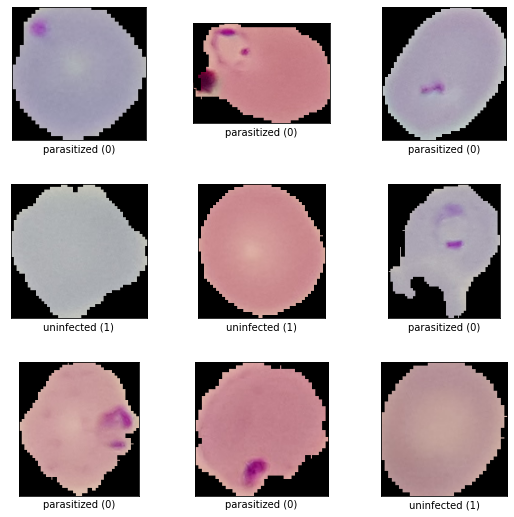

In [5]:
fig = tfds.show_examples(train_ds, metadata)

In [6]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 19291
Num validating images: 4133
Num testing images: 4134


In [7]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label

In [8]:
# add some padding to the images
padded_train_ds = (
    train_ds
    .map(pad)
) 

padded_val_ds = (
    val_ds
    .map(pad)
) 

padded_test_ds = (
     test_ds
    .map(pad)
) 

[Prefetching](https://www.tensorflow.org/guide/data_performance) <br>
Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

Note that the prefetch transformation provides benefits any time there is an opportunity to overlap the work of a "producer" with the work of a "consumer."

In [9]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

#augment the images with random flips and rotations

# Random flip: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip
# Flips training images randomly either horizontally or vertically

# Random rotation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation
# Flip images randomly during training, according to fractions of 2Pi. In this case the rotations are up to pi/4
# fill mode: The input is extended by filling all values beyond the edge with the same constant value k = 0.

# This data augmentation method should be classification invariant, i.e., the labels are not effected by transformations.

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.25, fill_mode="constant"),
])

IMG_SIZE = 224

# resize to input shape preferred by efficientnetB0
# this is 224x224 accoring to https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
# API link: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing
# crop to aspect ratio should be the default, we have square images so it doesn't matter
resize_and_rescale = tf.keras.Sequential([
  Resizing(IMG_SIZE, IMG_SIZE, crop_to_aspect_ratio=True),
  Rescaling(255)
])

batch_size = 32
#AUTOTUNE should automatically optimize performance
AUTOTUNE = tf.data.AUTOTUNE

#Function that implements data augmentation
def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets. 
  # Lambda function takes dataset as argument, resizes and rescales images, doesn't modify labels
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  # Lambda function takes dataset as argument, augments images, doesn't modify labels
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

# Show some cool examples of cells and illustration of data augmentation

In [10]:
get_label_name = metadata.features['label'].int2str

image_iterable = iter(padded_train_ds)

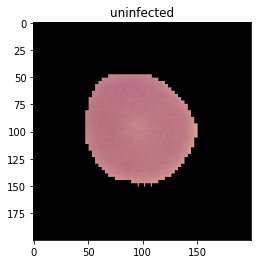

In [11]:
# rerun this cell to get other images

image, label = next(image_iterable)
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

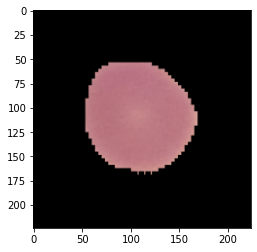

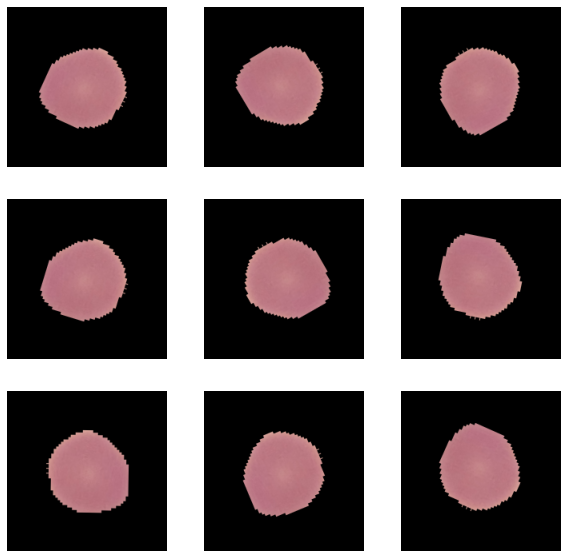

In [12]:
result = resize_and_rescale(image)
_ = plt.imshow(result/255)
# Add the image to a batch.
image = tf.expand_dims(image, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [13]:
train_ds = prepare(padded_train_ds, shuffle=True, augment=True).repeat(1) # repeat 5 made training time very long. I'll run this with repeat 2-3 if I have time.
val_ds = prepare(padded_val_ds)
test_ds = prepare(padded_test_ds)

# It's time to build the model

In [38]:
# create new model on top
def create_model():
  input = Input(shape=(224, 224, 3))
  x = base_model(input, training=False)
  x = Dense(256, activation='relu')(x) # decision layer sizes according to Timo's suggestion
  x = Dense(64, activation='relu')(x)
  predictions = Dense(1, activation='sigmoid')(x)
  return Model(inputs=input, outputs=predictions)

# create the model

model = create_model()

# freeze the base model layers
base_model.trainable = False

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())

In [40]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,394,020
Trainable params: 344,449
Non-trainable params: 4,049,571
_________________________________________________________________


# Let's define checkpoint and early stopping callbacks

In [19]:
checkpoint_path = "models/transfer-net.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# to clarify this keeps one checkpoint saved, I think this is sufficient.
# in case something goes wrong you can always retrain the model.
# This serves as a starting point for fine-tuning.
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

# Now it's time to establish a baseline for performance

In [20]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=20, # early stopping probably stops this before epoch 20
          verbose='auto',
          callbacks=callbacks)

603/603 [==============================] - ETA: 0s - loss: 0.1786 - binary_accuracy: 0.9300
Epoch 00001: saving model to models/transfer-net.ckpt
603/603 [==============================] - 26s 37ms/step - loss: 0.1786 - binary_accuracy: 0.9300 - val_loss: 0.1373 - val_binary_accuracy: 0.9475


In [21]:
model.evaluate(test_ds)

130/130 [==============================] - 3s 25ms/step - loss: 0.1480 - binary_accuracy: 0.9473


[0.14800040423870087, 0.9472665786743164]

# Plot history

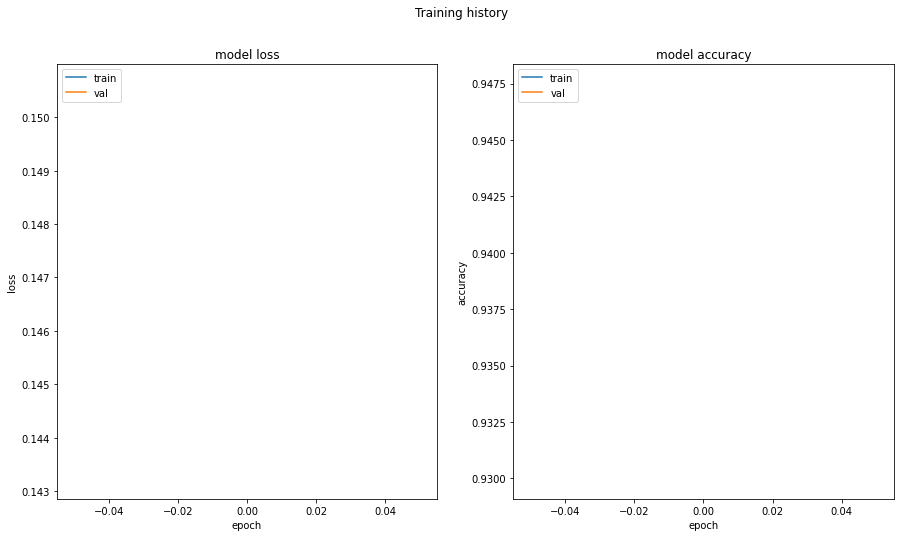

In [22]:
def plot_training_metrics(history):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
  fig.suptitle('Training history')

  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('model loss')
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'val'], loc='upper left')
  ax1.set_ylim(min(history.history['loss'])*0.8, max(history.history['val_loss'])*1.1)

  ax2.plot(history.history['binary_accuracy'])
  ax2.plot(history.history['val_binary_accuracy'])
  ax2.set_title('model accuracy')
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'val'], loc='upper left')

  plt.show()

plot_training_metrics(history)

We can see from the plot that training loss and accuracy were steadily improving. However, validation loss and accuracy was already fluctuating after about epoch 3. <br>
Further training would increase risk of overfitting, as out training data was pretty compact. It's time to try fine-tuning the model.

# Fine-tuning the model

Let's try to fine-tune the model by opening up a few layers. First we will open up first layer block, and then in the second iteration the final layer block before decision part.

In [41]:
print(model.summary())
trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_params)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,394,020
Trainable params: 344,449
Non-trainable params: 4,049,571
_________________________________________________________________
None
344449


In [47]:
# Loads the weights
model.load_weights(checkpoint_path).expect_partial()

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - 1)

# Unfreeze block 1
base_model.trainable = True

for layer in base_model.layers:
    if "block1" not in layer.name:
        layer.trainable = False
# This opened up  1448 parameters for training.


# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
# default learning rate in Adam is  0.001. 1e-6 is much smaller
adam = tf.keras.optimizers.Adam(
    learning_rate=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())
trainable_params_2 = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_params_2 - trainable_params)
print(model.summary())

130/130 - 4s - loss: 0.1480 - binary_accuracy: 0.9473 - 4s/epoch - 30ms/step
Restored model, validation accuracy: 94.73%
Number of layers in the base model:  238
Number of layers in the decision model:  4
1448
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                               

603/603 [==============================] - ETA: 0s - loss: 0.1361 - binary_accuracy: 0.9523
Epoch 00001: saving model to models/transfer-net-finetuned.ckpt
603/603 [==============================] - 83s 132ms/step - loss: 0.1361 - binary_accuracy: 0.9523 - val_loss: 0.1197 - val_binary_accuracy: 0.9555


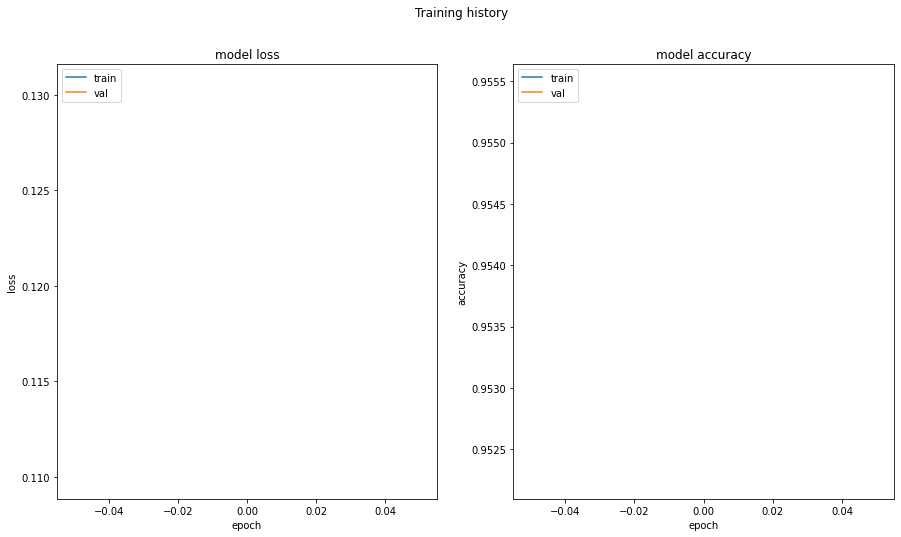

130/130 - 3s - loss: 0.1330 - binary_accuracy: 0.9557 - 3s/epoch - 26ms/step
Fine-tuned model, validation accuracy: 95.57%


In [44]:
ft_checkpoint_path = "models/transfer-net-finetuned.ckpt"
ft_checkpoint_dir = os.path.dirname(ft_checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

fine_tune_epochs = 30
total_epochs =  history.epoch[-1] + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Fine-tuned model, validation accuracy: {:5.2f}%".format(100 * acc))

#### Fine-tuning, round 2
Let's now unfreeze the second layer block and repeat the training otherwise in an identical manner.

In [48]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,394,020
Trainable params: 345,897
Non-trainable params: 4,048,123
_________________________________________________________________
None


In [54]:
# Loads the weights
model.load_weights(ft_checkpoint_path).expect_partial()

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - 1)

# Unfreeze block 1
base_model.trainable = True

for layer in base_model.layers:
    if "block2" not in layer.name:
        layer.trainable = False
# This opened up about 15266 parameters for training.


# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
# default learning rate in Adam is  0.001. 1e-6 is much smaller
adam = tf.keras.optimizers.Adam(
    learning_rate=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())
trainable_params_3 = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_params_3 - trainable_params_2)
print(model.summary())

130/130 - 4s - loss: 0.1330 - binary_accuracy: 0.9557 - 4s/epoch - 29ms/step
Restored model, validation accuracy: 95.57%
Number of layers in the base model:  238
Number of layers in the decision model:  4
15266
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                              

In [55]:
ft_checkpoint_path_2 = "models/transfer-net-finetuned-2.ckpt"
ft_checkpoint_dir_2 = os.path.dirname(ft_checkpoint_path_2)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_2,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

fine_tune_epochs = 30
total_epochs =  history_fine.epoch[-1] + fine_tune_epochs

history_fine_2 = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine_2)
# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Fine-tuned model, test accuracy: {:5.2f}%".format(100 * acc))

Epoch 1/20
603/603 [==============================] - ETA: 0s - loss: 0.1173 - binary_accuracy: 0.9589
Epoch 00001: saving model to models/transfer-net-finetuned-2.ckpt
603/603 [==============================] - 72s 114ms/step - loss: 0.1173 - binary_accuracy: 0.9589 - val_loss: 0.0977 - val_binary_accuracy: 0.9613
Epoch 2/20
 27/603 [>.............................] - ETA: 1:04 - loss: 0.0967 - binary_accuracy: 0.9676

KeyboardInterrupt: 

In [56]:
# Loads the weights from previous checkpoint
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored baseline model, accuracy: {:5.2f}%".format(100 * acc))

# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path_2)

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

130/130 - 3s - loss: 0.1480 - binary_accuracy: 0.9473 - 3s/epoch - 26ms/step
Restored baseline model, accuracy: 94.73%
130/130 - 3s - loss: 0.1111 - binary_accuracy: 0.9615 - 3s/epoch - 26ms/step
Restored fine-tuned model, accuracy: 96.15%


## Train the model again with L2 regularization, batch normalization, dropout layer and learning rate scheduler

Let's implement the above changes to the model and compare the result to the model trained with Adam.

In [57]:
# create new model on top
def create_model():
  input = Input(shape=(224, 224, 3))
  x = base_model(input, training=False)
  x = BatchNormalization()(x)
  x = Dense(256, activation='relu', kernel_regularizer='l2')(x) # decision layer sizes according to Timo's suggestion
  x = Dense(64, activation='relu', kernel_regularizer='l2')(x)
  x = Dropout(0.1)(x)
  predictions = Dense(1, activation='sigmoid')(x)
  return Model(inputs=input, outputs=predictions)

# create the model

model = create_model()

# freeze the base model layers
base_model.trainable = False

In [59]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=500,
    decay_rate=0.9)

SGD = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule, momentum=0.8, nesterov=False,
)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

lr_metric = get_lr_metric(SGD)

model.compile(optimizer=SGD, loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), lr_metric])
trainable_lr_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_lr_params)

347009


In [60]:
checkpoint_path_lr = "models/transfer-net-lr.ckpt"
checkpoint_dir_lr = os.path.dirname(checkpoint_path_lr)

# Create a callback that saves the model's weights
# to clarify this keeps one checkpoint saved, I think this is sufficient.
# in case something goes wrong you can always retrain the model.
# This serves as a starting point for fine-tuning.
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_lr,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

history_lr = model.fit(train_ds,
          validation_data=val_ds,
          epochs=20, # early stopping probably stops this before epoch 20
          verbose='auto',
          callbacks=callbacks)

601/603 [============================>.] - ETA: 0s - loss: 3.2864 - binary_accuracy: 0.9554 - lr: 0.0094
Epoch 00001: saving model to models/transfer-net-lr.ckpt
603/603 [==============================] - 24s 36ms/step - loss: 3.2823 - binary_accuracy: 0.9554 - lr: 0.0094 - val_loss: 1.8223 - val_binary_accuracy: 0.9627 - val_lr: 0.0088


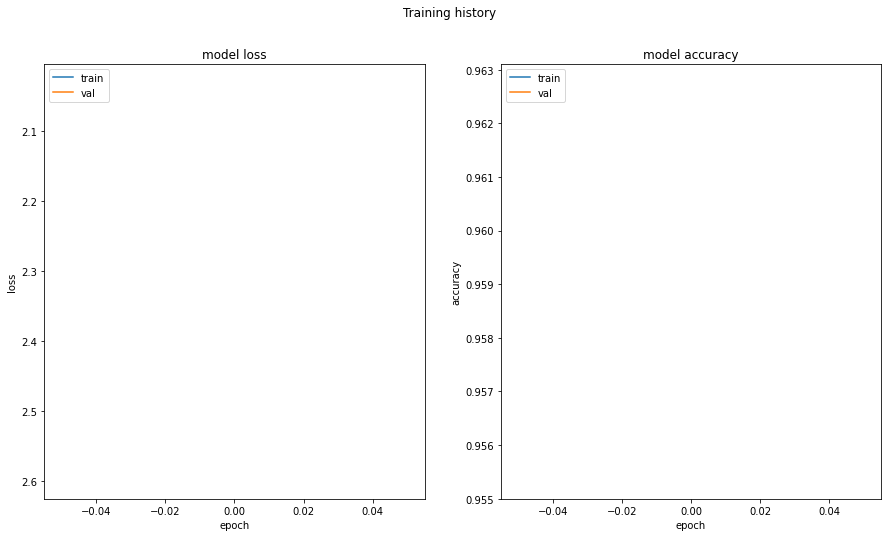

130/130 - 3s - loss: 1.8338 - binary_accuracy: 0.9615 - lr: 0.0088 - 3s/epoch - 26ms/step
Model, test accuracy: 96.15%


In [61]:
plot_training_metrics(history_lr)
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Model, test accuracy: {:5.2f}%".format(100 * acc))

### Fine-tune the model by unfreezing the first layer block

130/130 - 3s - loss: 1.8338 - binary_accuracy: 0.9615 - lr: 0.0088 - 3s/epoch - 26ms/step
Restored model, test accuracy: 96.15%
Number of layers in the base model:  238
Number of layers in the decision model:  6
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense_9 (Dense)             (None, 256)               327936    
                                                                 
 dense_10 (Dense)            (None, 64)      

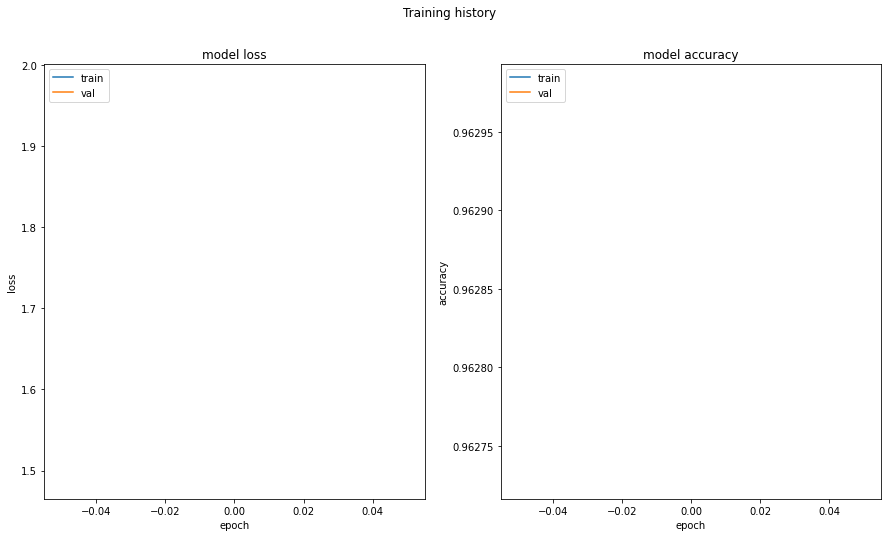

130/130 - 3s - loss: 1.8316 - binary_accuracy: 0.9613 - lr: 8.8068e-06 - 3s/epoch - 25ms/step
Fine-tuned model, validation accuracy: 96.13%


In [62]:
# Loads the weights
model.load_weights(checkpoint_path_lr).expect_partial()

# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Restored model, test accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - 1)

# Unfreeze block 1
base_model.trainable = True

for layer in base_model.layers:
    if "block1" not in layer.name:
        layer.trainable = False
# This opened up 1448 parameters for training.


# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
# default learning rate in SGD is  0.01. 1e-5 is much smaller

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=500,
    decay_rate=0.9)

SGD = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule, momentum=0.8, nesterov=False,
)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

lr_metric = get_lr_metric(SGD)

model.compile(optimizer=SGD, loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), lr_metric])
print(model.summary())
trainable_lr_params_2 = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_lr_params_2 - trainable_lr_params)

ft_checkpoint_path_lr_ft = "models/transfer-net-finetuned-lr-ft.ckpt"
ft_checkpoint_dir_lr_ft = os.path.dirname(ft_checkpoint_path_lr_ft)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_lr_ft,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

fine_tune_epochs = 30
total_epochs =  history_lr.epoch[-1] + fine_tune_epochs

history_lr_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_lr_fine)
# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Fine-tuned model, validation accuracy: {:5.2f}%".format(100 * acc))

### Fine-tune the model by unfreezing the second layer block

130/130 - 3s - loss: 1.8316 - binary_accuracy: 0.9613 - lr: 8.8068e-06 - 3s/epoch - 26ms/step
Restored model, test accuracy: 96.13%
Number of layers in the base model:  238
Number of layers in the decision model:  6
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense_9 (Dense)             (None, 256)               327936    
                                                                 
 dense_10 (Dense)            (None, 64)  

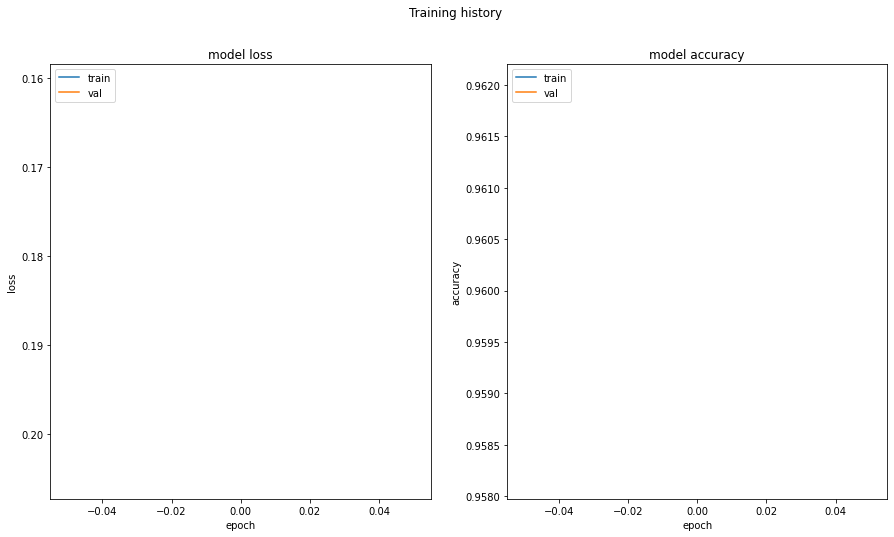

130/130 - 3s - loss: 0.1614 - binary_accuracy: 0.9598 - lr: 1.0000e-05 - 3s/epoch - 27ms/step
Fine-tuned model, test accuracy: 95.98%


In [63]:
# Loads the weights
model.load_weights(ft_checkpoint_path_lr_ft).expect_partial()

# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Restored model, test accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - 1)

# Unfreeze block 1
base_model.trainable = True

for layer in base_model.layers:
    if "block2" not in layer.name:
        layer.trainable = False
# This opened up 15266 parameters for training.


# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
# default learning rate in SGD is  0.01. 1e-5 is much smaller

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=500,
    decay_rate=0.9)

SGD = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule, momentum=0.8, nesterov=False,
)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

lr_metric = get_lr_metric(SGD)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), lr_metric])
print(model.summary())
trainable_lr_params_3 = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_lr_params_3 - trainable_lr_params_2)

ft_checkpoint_path_lr_ft_2 = "models/transfer-net-finetuned-lr-2.ckpt"
ft_checkpoint_dir_lr_ft_2 = os.path.dirname(ft_checkpoint_path_lr_ft_2)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_lr_ft_2,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

fine_tune_epochs = 30
total_epochs =  history_lr_fine.epoch[-1] + fine_tune_epochs

history_lr_fine_2 = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_lr_fine_2)
# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Fine-tuned model, test accuracy: {:5.2f}%".format(100 * acc))

## Compare the two methods of training the model.

We first trained the model with optimizer Adam and no L2 regularization, learning rate scheduling, batch normalization or dropout. <br>
On  the second run we added the above methods, but trained the model otherwise in an identical manner with SGD and learning rate scheduler.
Let's now compare the final models.

In [64]:
# Loads the weights from previous checkpoint
model.load_weights(checkpoint_path_lr)

# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Restored baseline model, accuracy: {:5.2f}%".format(100 * acc))

# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path_lr_ft_2)

# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Restored fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

130/130 - 3s - loss: 1.8338 - binary_accuracy: 0.9615 - lr: 1.0000e-05 - 3s/epoch - 26ms/step
Restored baseline model, accuracy: 96.15%
130/130 - 3s - loss: 0.1614 - binary_accuracy: 0.9598 - lr: 1.0000e-05 - 3s/epoch - 26ms/step
Restored fine-tuned model, accuracy: 95.98%


# Results

Performance of baseline was about 95.10%. After first round of finetuning with low learning rate performance was 96.88%. After the final round of fine-tuning with learning rate scheduler, the final performance on test set was 96.95%. Not great, not terrible. Could definitely be higher.

## Examples of erroneous predictions

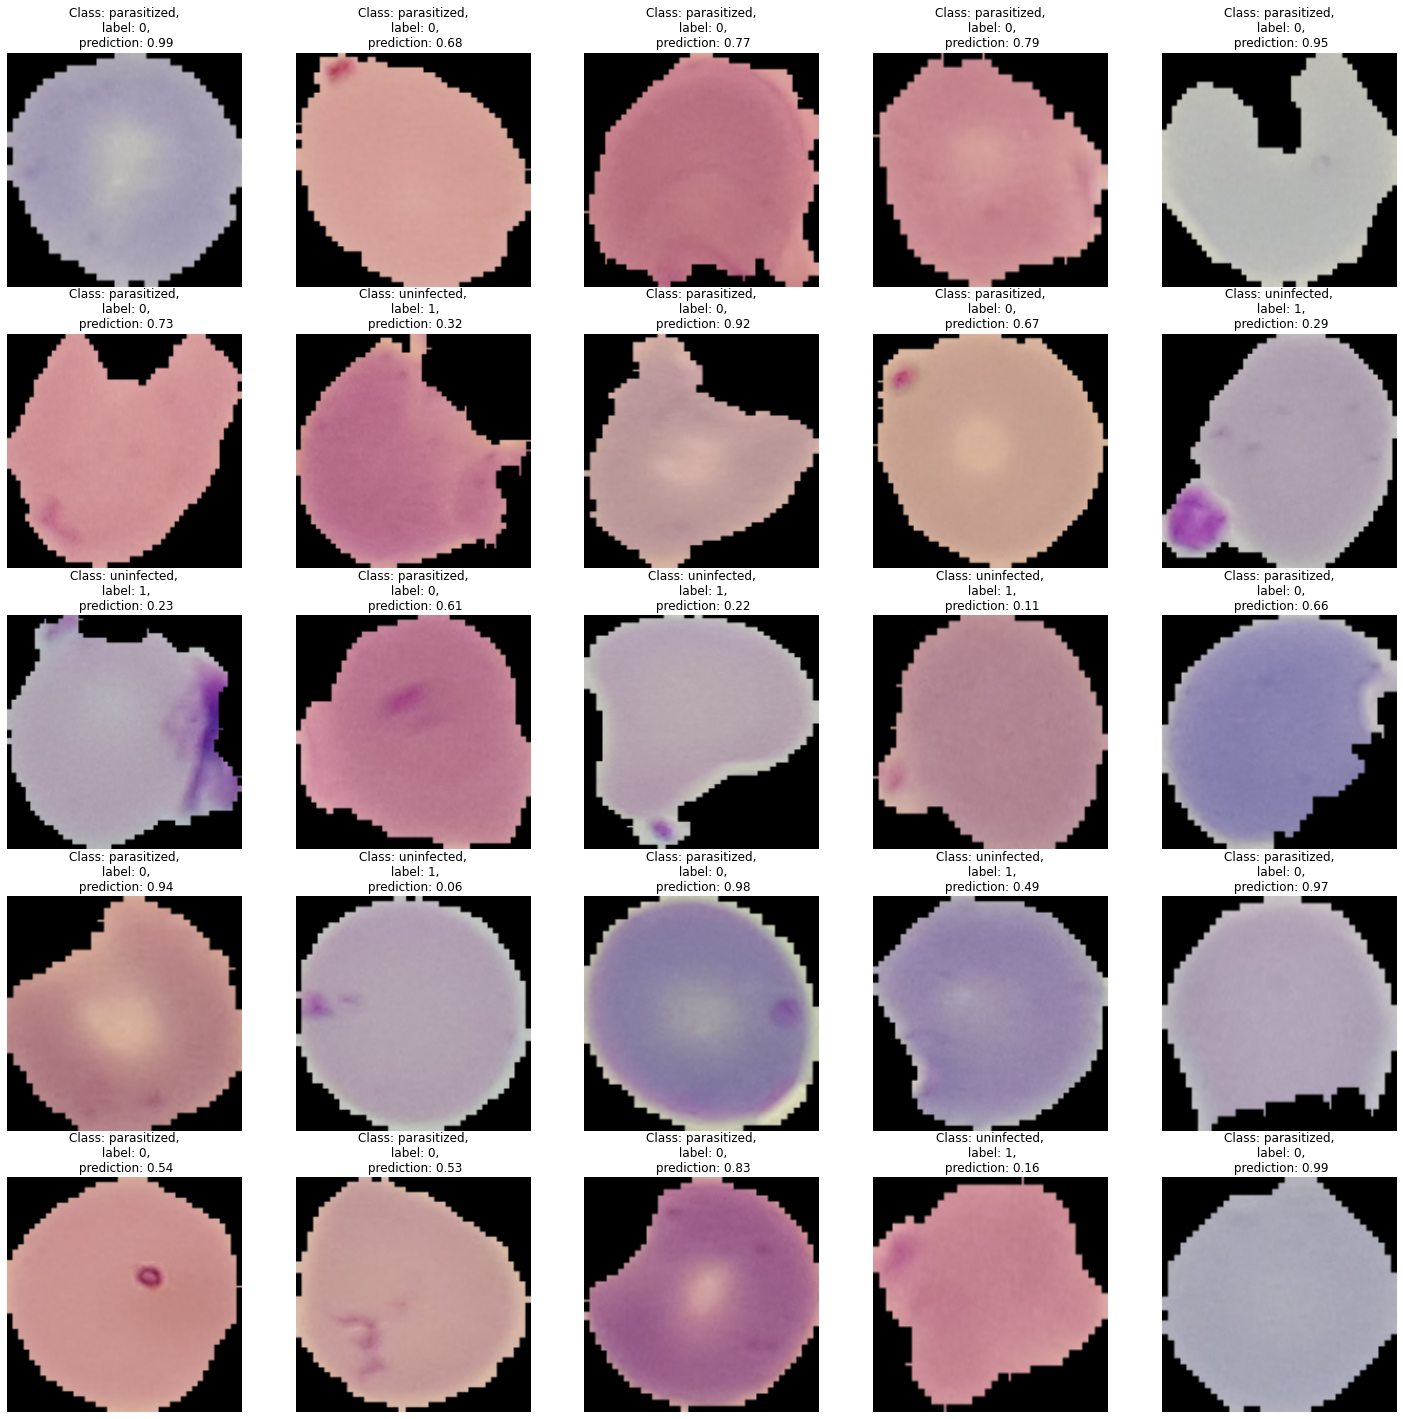

In [28]:
plt.figure(figsize=(25, 25))

false_predictions = 0

for set in test_ds:

    if false_predictions == 25:
      break

    predictions = model.predict(set[0])
    for i in range(len(predictions)):

        label = int(set[1][i])

        if label != round(predictions[i][0]):
          false_predictions += 1
          label_name = get_label_name(label)
          prediction = predictions[i]
          ax = plt.subplot(5, 5, false_predictions)
          plt.imshow(set[0][i]/255)
          plt.axis("off")
          ax.set_title(f'Class: {label_name},\n label: {label},\n prediction: {"%.2f" % prediction[0]}')
          if false_predictions == 25:
            break
plt.show()